In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

import numpy as np
import math, random
import matplotlib.pyplot as plt

import pandas as pd
from pandas.plotting import scatter_matrix
import h5py, json
import os,time,sys


from importlib import reload

sys.path.append('/content/drive/MyDrive/Colab Notebooks/fidle-master')
import fidle.pwk as pwk

run_dir = '/content/drive/MyDrive/Colab Notebooks'


pd.set_option('display.max_rows',200)

In [ ]:
 # ---- About dataset (no need to change)
#
dataset_dir      = '/content/drive/MyDrive/Colab Notebooks'                  # Enhanced dataset is very small, so ./data in a good choice :-)
dataset_filename = 'synop-LYSinterpole.csv'
schema_filename  = 'synopinterpole.json'
features         = ['Température','mois_de_l_annee','Humidité']
features_len     = len(features)

# ---- About training (Can be changed !)
#
scale            = 1        # Percentage of dataset to be used (1=all)
train_prop       = .8       # Percentage for train (the rest being for the test)
sequence_len     = 32
batch_size       = 64
epochs           = 10
fit_verbosity    = 1        # 0 = silent, 1 = progress bar, 2 = one line per epoch

In [ ]:
 pwk.override('scale', 'train_prop', 'sequence_len', 'batch_size', 'epochs', 'fit_verbosity')

In [ ]:
# ---- Read dataset from ./data

df = pd.read_csv(f'{dataset_dir}/{dataset_filename}', header=0, sep=';')
df

,Date,Température,Humidité,communes (name),department (name),mois_de_l_annee
0,2010-01-01T01:00:00+01:00,275.25,97.0,Barberey-Saint-Sulpice,Aube,1
1,2010-01-01T01:00:00+01:00,273.95,94.0,Athis-Mons,Essonne,1
2,2010-01-01T01:00:00+01:00,278.05,89.0,Saint-Aignan-Grandlieu,Loire-Atlantique,1
3,2010-01-01T04:00:00+01:00,274.35,96.0,Barberey-Saint-Sulpice,Aube,1
4,2010-01-01T04:00:00+01:00,273.75,89.0,Athis-Mons,Essonne,1
...,...,...,...,...,...,...
33906,2013-11-06T19:00:00+01:00,287.65,87.0,Barberey-Saint-Sulpice,Aube,11
33907,2013-11-06T19:00:00+01:00,288.15,84.0,Athis-Mons,Essonne,11
33908,2013-11-06T19:00:00+01:00,288.55,89.0,Saint-Aignan-Grandlieu,Loire-Atlantique,11
33909,2013-11-06T22:00:00+01:00,288.05,85.0,Barberey-Saint-Sulpice,Aube,11


In [ ]:
# ---- First of all, we have to sort on the date

df.sort_values(by='Date',  inplace=True)
df.reset_index(drop=True, inplace=True)

# ---- Before : Lines with NaN

na_rows=df.isna().any(axis=1)
pwk.subtitle('Before :')
display( df[na_rows].head(50) )

# ---- Nice interpolation for plugging holes

df.interpolate(inplace=True)

# ---- After

pwk.subtitle('After :')
display(df[na_rows].head(50))

In [ ]:


# ---- Scaling

df = df[:int(scale*len(df))]
train_len=int(train_prop*len(df))
print (train_len)
# ---- Train / Test
dataset_train = df.loc[ :train_len-1, features ]
dataset_test  = df.loc[train_len:,    features ]
pwk.subtitle('Train dataset example :')
display(dataset_train.head(31))

# ---- Normalize, and convert to numpy array

mean = dataset_train.mean()
std  = dataset_train.std()
dataset_train = (dataset_train - mean) / std
dataset_test  = (dataset_test  - mean) / std

pwk.subtitle('After normalization :')
display(dataset_train.describe().style.format("{0:.2f}"))

dataset_train = dataset_train.to_numpy()
dataset_test  = dataset_test.to_numpy()

pwk.subtitle('Shapes :')
print('Dataset       : ',df.shape)
print('Train dataset : ',dataset_train.shape)
print('Test  dataset : ',dataset_test.shape)

In [ ]:
# ---- Train generator

train_generator = TimeseriesGenerator(dataset_train, dataset_train, length=sequence_len,  batch_size=batch_size)
test_generator  = TimeseriesGenerator(dataset_test,  dataset_test,  length=sequence_len,  batch_size=batch_size)

# ---- About

pwk.subtitle('About the splitting of our dataset :')

x,y=train_generator[0]
print(f'Nombre de train batchs disponibles : ', len(train_generator))
print('batch x shape : ',x.shape)
print('batch y shape : ',y.shape)

x,y=train_generator[0]
pwk.subtitle('What a batch looks like (x[0]) :')
pwk.np_print(x[0] )
pwk.subtitle('What a batch looks like (y[0]) :')
pwk.np_print(y[0])

In [ ]:
model = keras.models.Sequential()
model.add( keras.layers.InputLayer(input_shape=(sequence_len, features_len)) )
model.add( keras.layers.LSTM(100, activation='relu') ) #bon ca doit pas etre normal
model.add( keras.layers.Dropout(0.2) )
model.add( keras.layers.Dense(features_len) )

model.summary()

In [ ]:
pwk.mkdir(run_dir)
save_dir = f'{run_dir}/best_model.h5'
bestmodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir, verbose=0, save_best_only=True)

In [ ]:
 model.compile(optimizer='adam', 
              loss='mse', 
              metrics   = ['mae'] )

In [ ]:
 pwk.chrono_start()

history=model.fit(train_generator, 
                  epochs  = 5, 
                  verbose = fit_verbosity,
                  validation_data = test_generator,
                  callbacks = [bestmodel_callback])

pwk.chrono_show()

Epoch 1/5
424/424 [==============================] - 28s 57ms/step - loss: 13.3187 - mae: 0.6263 - val_loss: 0.2484 - val_mae: 0.3692
Epoch 2/5
424/424 [==============================] - 23s 55ms/step - loss: 0.2462 - mae: 0.3613 - val_loss: 0.1794 - val_mae: 0.2975
Epoch 3/5
424/424 [==============================] - 23s 55ms/step - loss: 0.1939 - mae: 0.3119 - val_loss: 0.1519 - val_mae: 0.2564
Epoch 4/5
424/424 [==============================] - 24s 56ms/step - loss: 0.1777 - mae: 0.2952 - val_loss: 0.1436 - val_mae: 0.2503
Epoch 5/5
424/424 [==============================] - 24s 56ms/step - loss: 0.1671 - mae: 0.2852 - val_loss: 0.1390 - val_mae: 0.2411

Duration :  00:02:03 531ms


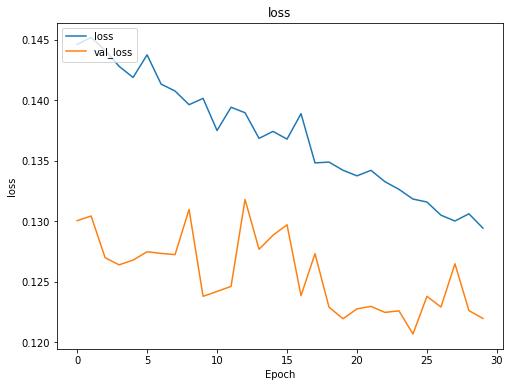

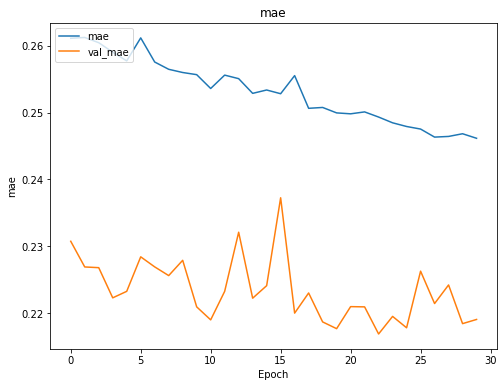

In [ ]:
 pwk.plot_history(history,plot={'loss':['loss','val_loss'], 'mae':['mae','val_mae']}, save_as='01-history') 



In [ ]:
 loaded_model1 = tf.keras.models.load_model(f'{run_dir}/best_model.h5')

A partir de là, on double tout le code pour cette fois faire le modele uniquement sur les données d'une ville


In [ ]:
dataset_filename = 'synop-LYSinterpole.csv'
schema_filename  = 'synopinterpole.json'
features         = ['Température','mois_de_l_annee','Humidité']
features_len     = len(features)

# ---- About training (Can be changed !)
#
scale            = 1        # Percentage of dataset to be used (1=all)
train_prop       = .8       # Percentage for train (the rest being for the test)
sequence_len     = 32
batch_size       = 64
epochs           = 10
fit_verbosity    = 1        # 0 = silent, 1 = progress bar, 2 = one line per epoch

In [ ]:
 pwk.override('scale', 'train_prop', 'sequence_len', 'batch_size', 'epochs', 'fit_verbosity')

In [ ]:
# ---- Read dataset from ./data

df = pd.read_csv(f'{dataset_dir}/{dataset_filename}', header=0, sep=';')
df1 = pd.DataFrame( df.iloc[0])
# ---- Scaling

for i in range (0,len(df),3):
  df1[i//3]=(df.iloc[i])
df1 = df1[:int(scale*len(df1))]
df1=df1.T
train_len1=int(train_prop*len(df1))


# ---- Train / Test
dataset_train1 = df1.loc[ :train_len1-1, features ]
dataset_test1  = df1.loc[train_len1:,    features ]
pwk.subtitle('Train dataset example :')
display(dataset_train1.head(31))

# ---- Normalize, and convert to numpy array

mean1 = dataset_train1.mean()
std1  = dataset_train1.std()
dataset_train1 = (dataset_train1 - mean1) / std1
dataset_test1  = (dataset_test1  - mean1) / std1

pwk.subtitle('After normalization :')
display(dataset_train1.describe().style.format("{0:.2f}"))

dataset_train1 = dataset_train1.to_numpy()
dataset_test1  = dataset_test1.to_numpy()

pwk.subtitle('Shapes :')
print('Dataset       : ',df1.shape)
print('Train dataset : ',dataset_train1.shape)
print('Test  dataset : ',dataset_test1.shape)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  


<br>**Train dataset example :**

,Température,mois_de_l_annee,Humidité
0,275.25,1,97.0
1,274.35,1,96.0
2,273.95,1,93.0
3,273.85,1,87.0
4,273.85,1,83.0
5,273.45,1,84.0
6,273.15,1,86.0
7,273.35,1,81.0
8,271.05,1,87.0
9,270.85,1,83.0


<br>**After normalization :**

,Température,mois_de_l_annee,Humidité
count,9037.00,9038.00,9034.00
unique,490.00,12.00,110.00
top,-0.26,-1.53,0.69
freq,58.00,972.00,378.00


<br>**Shapes :**

Dataset       :  (11298, 6)
Train dataset :  (9038, 3)
Test  dataset :  (2260, 3)


In [ ]:
# ---- Train generator
sequence_len1=sequence_len//3
batch_size1=2*sequence_len1

#sequence_len1=sequence_len
#batch_size1=batch_size

train_generator1 = TimeseriesGenerator(dataset_train1, dataset_train1, length=sequence_len1,  batch_size=batch_size1)
test_generator1  = TimeseriesGenerator(dataset_test1,  dataset_test1,  length=sequence_len1,  batch_size=batch_size1)

# ---- About

pwk.subtitle('About the splitting of our dataset :')

x,y=train_generator1[0]
print(f'Nombre de train batchs disponibles : ', len(train_generator1))
print('batch x shape : ',x.shape)
print('batch y shape : ',y.shape)

x,y=train_generator1[0]
pwk.subtitle('What a batch looks like (x[0]) :')
pwk.np_print(x[0] )
pwk.subtitle('What a batch looks like (y[0]) :')
pwk.np_print(y[0])
print (batch_size1)

<br>**About the splitting of our dataset :**

Nombre de train batchs disponibles :  452
batch x shape :  (20, 10, 3)
batch y shape :  (20, 3)


<br>**What a batch looks like (x[0]) :**

[[-1.1049068321861397 -1.5335878005057677 1.147146073674779]
 [-1.2196220254943586 -1.5335878005057677 1.089784404688026]
 [-1.2706065558535726 -1.5335878005057677 0.9176993977277671]
 [-1.2833526884433706 -1.5335878005057677 0.5735293838072495]
 [-1.2833526884433706 -1.5335878005057677 0.3440827078602377]
 [-1.3343372188025846 -1.5335878005057677 0.40144437684699064]
 [-1.3725756165719933 -1.5335878005057677 0.5161677148204965]
 [-1.3470833513923828 -1.5335878005057677 0.2293593698867318]
 [-1.6402444009578396 -1.5335878005057677 0.5735293838072495]
 [-1.665736666137443 -1.5335878005057677 0.3440827078602377]]


<br>**What a batch looks like (y[0]) :**

[-1.8186902572150778 -1.5335878005057677 0.5735293838072495]
20


In [ ]:
model1 = keras.models.Sequential()
model1.add( keras.layers.InputLayer(input_shape=(sequence_len1, features_len)) )
model1.add( keras.layers.LSTM(100, activation='relu') ) #bon ca doit pas etre normal
model1.add( keras.layers.Dropout(0.2) )
model1.add( keras.layers.Dense(features_len) )

model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 100)               41600     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 303       
                                                                 
Total params: 41,903
Trainable params: 41,903
Non-trainable params: 0
_________________________________________________________________


In [ ]:
pwk.mkdir(run_dir)
save_dir1 = f'{run_dir}/best_model1.h5'
bestmodel_callback1 = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir1, verbose=0, save_best_only=True)
print(bestmodel_callback1)


In [ ]:
 model1.compile(optimizer='adam', 
              loss='mse', 
              metrics   = ['mae'] )

In [ ]:
 pwk.chrono_start()

history1=model1.fit(train_generator1, 
                  epochs  = epochs, 
                  verbose = fit_verbosity,
                  validation_data = test_generator1,
                  callbacks = [bestmodel_callback1])

pwk.chrono_show()

ValueError: ignored

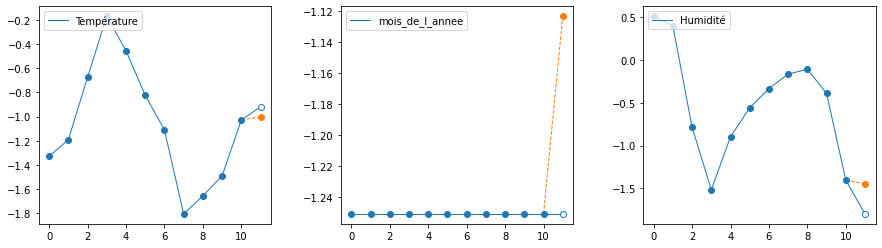

In [ ]:
s1=random.randint(0,(len(dataset_test)-sequence_len)//3)
s=3*s1      #comme ca on peut décider où on commence pour la séquence (ici à Barberey)
#sequence      = dataset_test[i in range(s,s+sequence_len,1)]
sequence      = dataset_test[s:s+sequence_len]
#sequence_true = dataset_test[s:s+sequence_len+1]
sequence2=[]
sequence_true2=[]
for i in range (s,s+sequence_len,1):
  sequence2.append(dataset_test[i])
for i in range (s,s+sequence_len+3,3):
  sequence_true2.append(dataset_test[i])

pred = loaded_model1.predict( np.array([sequence2]) )

# ---- Show result
pwk.plot_multivariate_serie(np.array(sequence_true2), predictions=pred, labels=features, save_as='02-prediction-norm')

(1, 32, 3)


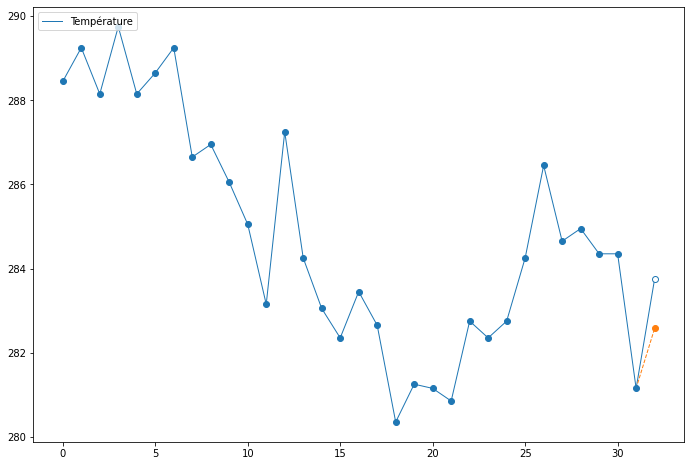

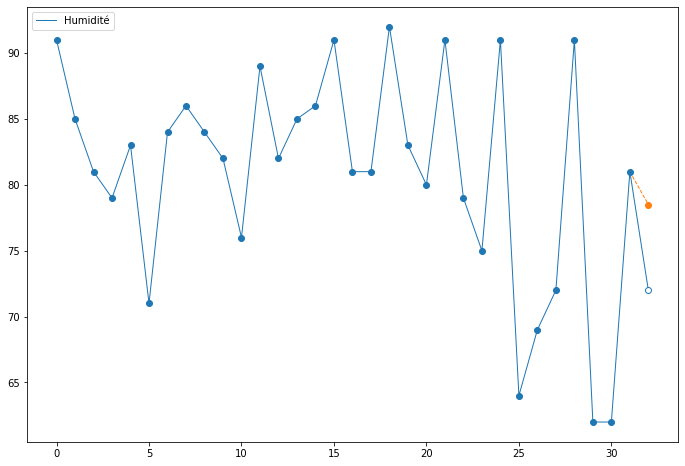

Gap between prediction and reality : 1.17 °C


In [ ]:
def denormalize(mean,std,seq):
    nseq = seq.copy()
    for i,s in enumerate(nseq):
        s = s*std + mean
        nseq[i]=s
    return nseq


# ---- Get a sequence
s1=random.randint(0,(len(dataset_test)-sequence_len)//3)
s=3*s1      #comme ca on peut décider où on commence pour la séquence (ici à Barberey)
sequence      = dataset_test[i:i+sequence_len]
sequence_true = dataset_test[i:i+sequence_len+1]
sequence2=[]
sequence_true2=[]
for i in range (s,s+sequence_len,1):
  sequence2.append(dataset_test[i])
for i in range (s,s+sequence_len+3,3):
  sequence_true2.append(dataset_test[i])




# ---- Prediction
print (np.array([sequence]).shape)
pred = loaded_model1.predict( np.array([sequence]) )


# ---- De-normalization

sequence_true = denormalize(mean,std, np.array(sequence_true))
pred          = denormalize(mean,std, pred)

# ---- Show it
feat=0 #la feature "température"
feat2=2 #la feature 'humidité"

pwk.plot_multivariate_serie(sequence_true, predictions=pred, labels=features, only_features=[feat],width=14, height=8, save_as='03-prediction')

delta_deg=abs(sequence_true[-1][feat]-pred[-1][feat])

pwk.plot_multivariate_serie(sequence_true, predictions=pred, labels=features, only_features=[feat2],width=14, height=8, save_as='03-prediction')

delta_deg=abs(sequence_true[-1][feat]-pred[-1][feat])
print(f'Gap between prediction and reality : {delta_deg:.2f} °C')